In [51]:
import pandas as pd
import numpy as np
import io
import sys
import os.path
import urllib.request
from tqdm import tqdm
from os import listdir
from PIL import Image
import glob
import pytesseract
# Link para descargar el ejecutable de tesseract: https://github.com/UB-Mannheim/tesseract/wiki
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
from Levenshtein import distance as lev
import cv2
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)

C:\Users\Ainhoa\AppData\Local\Temp\ipykernel_16584\490933250.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [16]:
df = pd.read_csv("MovieGenre.csv",encoding='ISO-8859-1')
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [17]:
#Remove NaN valued entries
df= df.dropna(how='any')
df = df.tail(200)
df.shape

(200, 6)

In [18]:
#Method 1 to download images
not_found = []
for index, row in tqdm(df.iterrows()):
    
    url = row['Poster']
    imdb_id = row['imdbId']
    
    file_path = "Posters/" + str(imdb_id) + ".jpg"
    
    try:
        response = urllib.request.urlopen(url)
        data = response.read()
        file = open(file_path, 'wb')
        file.write(bytearray(data))
        file.close()
    except:
        not_found.append(imdb_id)
        
print("Number of posters not found = ", len(not_found))
print("Following IMDB_ID posters were not found::", not_found)

200it [00:16, 12.11it/s]

Number of posters not found =  7
Following IMDB_ID posters were not found:: [2596918, 491603, 3000844, 54826, 67576, 88757, 83168]


# COMPARISON OF THE STRINGS IN THE IMAGES
#### The package pytesseract has been used for that purpose. This function extracts the words in the images and saves them in an array.

In [46]:
image1 = Image.open('Posters/27660.jpg')#load the first image
image2 = Image.open('Posters/19640.jpg')#load the second image

text1 = pytesseract.image_to_string(image1)#get the first text
text2 = pytesseract.image_to_string(image2)#get the second text

words1 = tuple(text1.split())
words2 = tuple(text2.split())

print(words1)
print(words2)


('THE', 'MILESTONE', 'COLLECTION')
('THE', 'LOST', 'FILMS', 'OF', 'dae', '(AUREL', '~', 'WARDY', 'THE', 'COMPLETE', 'COLLECTION', 'MERCI', 'TWO’')


3

#### After the words have been extracted, the levenshtein distance has been used to compare the similarity of the two tuples.

In [49]:
sum = 0
for i in range(len(words1)):
    for j in range(len(words2)):
      sum = sum + (lev(words1[i],words2[j]))
      
mean = sum/(len(words1)*len(words2))
print(mean)


6.512820512820513


# COMPARISON OF THE COLOR HISTOGRAMS

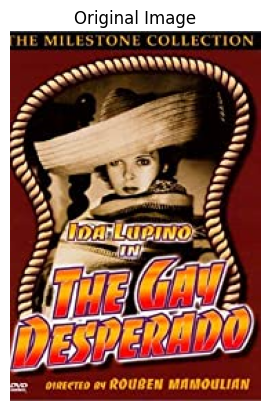

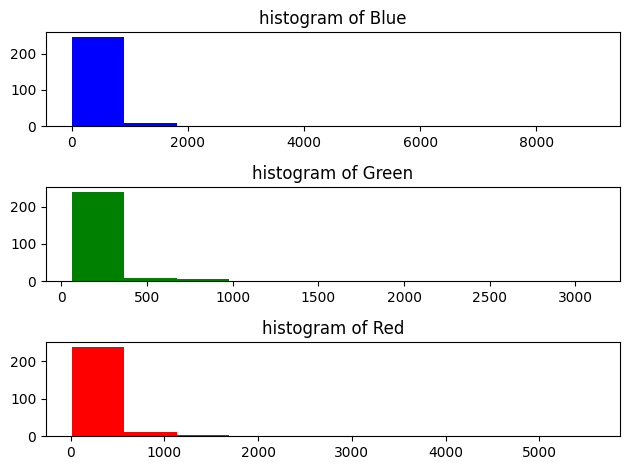

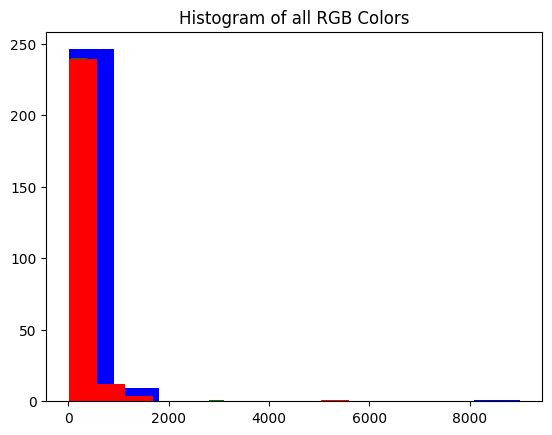

In [59]:
# load image
imageObj = cv2.imread(r'Posters/27660.jpg')
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(cv2.cvtColor(imageObj, cv2.COLOR_BGR2RGB))
plt.show()
  
# Get RGB data from image
blue_color = cv2.calcHist([imageObj], [0], None, [256], [0, 256])
red_color = cv2.calcHist([imageObj], [1], None, [256], [0, 256])
green_color = cv2.calcHist([imageObj], [2], None, [256], [0, 256])

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.hist(blue_color, color="blue")
  
plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.hist(green_color, color="green")
  
plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.hist(red_color, color="red")

# for clear view
plt.tight_layout()
plt.show()
  
# combined histogram
plt.title("Histogram of all RGB Colors")
plt.hist(blue_color, color="blue")
plt.hist(green_color, color="green")
plt.hist(red_color, color="red")
plt.show()

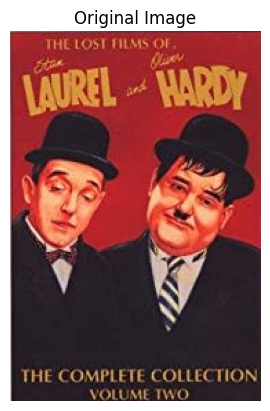

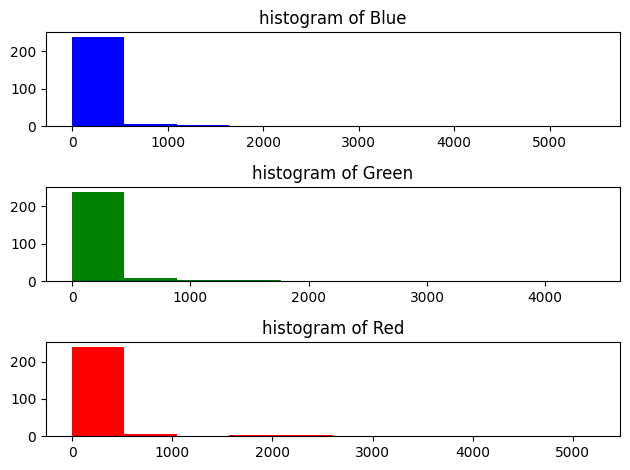

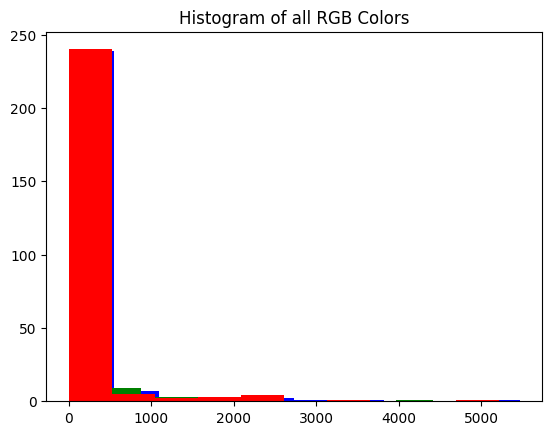

In [60]:
# load the second image
imageObj2 = cv2.imread(r'Posters/19640.jpg')
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(cv2.cvtColor(imageObj2, cv2.COLOR_BGR2RGB))
plt.show()
  
# Get RGB data from image
blue_color2 = cv2.calcHist([imageObj2], [0], None, [256], [0, 256])
red_color2 = cv2.calcHist([imageObj2], [1], None, [256], [0, 256])
green_color2 = cv2.calcHist([imageObj2], [2], None, [256], [0, 256])

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.hist(blue_color2, color="blue")
  
plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.hist(green_color2, color="green")
  
plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.hist(red_color2, color="red")

# for clear view
plt.tight_layout()
plt.show()
  
# combined histogram
plt.title("Histogram of all RGB Colors")
plt.hist(blue_color2, color="blue")
plt.hist(green_color2, color="green")
plt.hist(red_color2, color="red")
plt.show()

#### Correlation between the histograms of the two images

In [64]:
corrBlue = cv2.compareHist(blue_color,blue_color2,cv2.HISTCMP_CORREL)
print(corrBlue)
corrGreen = cv2.compareHist(green_color,green_color2,cv2.HISTCMP_CORREL)
print(corrGreen)
corrRed = cv2.compareHist(red_color,red_color2,cv2.HISTCMP_CORREL)
print(corrRed)

0.06368721917491359
0.03906163388866008
-0.006516342446830443


#### Intersection between the histograms of the two images

In [67]:
intBlue = cv2.compareHist(blue_color,blue_color2,cv2.HISTCMP_INTERSECT)
print(intBlue)
intGreen = cv2.compareHist(green_color,green_color2,cv2.HISTCMP_INTERSECT)
print(intGreen)
intRed = cv2.compareHist(red_color,red_color2,cv2.HISTCMP_INTERSECT)
print(intRed)

18836.0
21513.0
18519.0
